# Авторы
Студенты группы M3439:

- Тепляков Валерий
- Плешаков Алексей
- Филипчик Андрей

# Source code
Исходный код можно посмотреть [тут](https://github.com/Mervap/OptimizationMethods/tree/master/lab1)

# Задание 1

In [1]:
import datetime
import math

import numpy as np
import pandas as pd

from lab1.task1.golden_ratio import GoldenRatio
from lab1.task1.fibonacci import Fibonacci
from lab1.task1.dichotomy import Dichotomy
from lab1.task2.binary_search import BinarySearch
from lab1.task2.fastest_gradient_descent import FastestGradientDescent
from lab1.watcher import Watcher
import matplotlib.pyplot as plt

Для сравнения методов одномерного поиска возьмем следующую унимодальную на отрезке [2.2, 2.8] функцию:
$$f(x) = |\sin(x^2)|$$

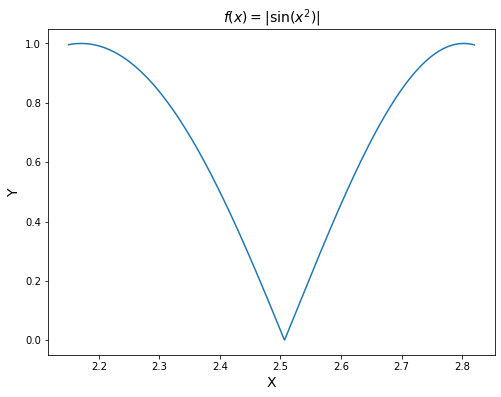

In [2]:
f = Watcher(lambda x: np.abs(np.sin(x ** 2)))
xs = np.linspace(2.15, 2.82, 1000)
ys = list(map(f, xs))
plt.figure(figsize=(8, 6))
plt.plot(xs, ys)
plt.xlabel("X", fontsize=14)
plt.ylabel("Y", fontsize=14)
plt.title("$f(x) = |\sin(x^2)|$", fontsize=14)
plt.show()

Сравним метод дихотомии, метод золотого сечения и метод Фибоначчи по количеству итераций и количеству вычислений функции в зависимости от запрашиваемой точности.

На графиках видно, что метод золотого сечения и метод Фибоначчи почти не отличаются по данным характеристикам. Метод Фибонначи на данной функции показывает результат всегда не хуже метода золотого сечения.

Метод дихотомии же использует меньшее количество итераций, но требует в $2$ раза больше вычислений функции. Это ожидаемый результат, так как другие два метода переиспользуют уже вычисленные значения.

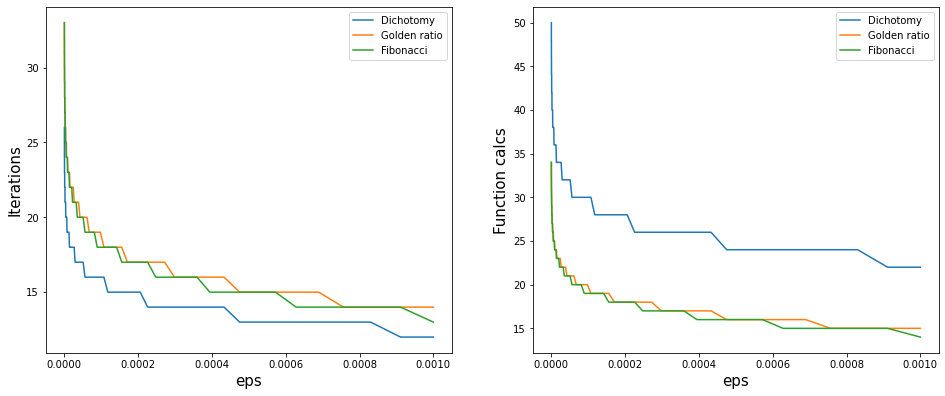

In [3]:
opts = [Dichotomy, GoldenRatio, Fibonacci]
fig = plt.figure(figsize=(16, 14))

# Eps/N
axn = fig.add_subplot(2, 2, 1)
axn.set_xlabel('eps', fontsize=15)
axn.set_ylabel('Iterations', fontsize=15)

# Eps/Calc
axc = fig.add_subplot(2, 2, 2)
axc.set_xlabel('eps', fontsize=15)
axc.set_ylabel('Function calcs', fontsize=15)

for opt_c in opts:
    epss = np.logspace(-7, -3, 100)
    ns = []
    calcs = []
    for eps in epss:
        opt = opt_c(f, eps, [2.2, 2.8])
        opt.opt()
        ns.append(len(opt.log_frame()))
        calcs.append(f.invocations)
    axn.plot(epss, ns, label=opt_c.name)
    axc.plot(epss, calcs, label=opt_c.name)

axn.legend()
axc.legend()
plt.show()

Также посмотрим как изменяется отрезок при переходе к следующей итерации (правый график приближение левого). Видно, что на первых итерациях метод дихотомии сокращает интервал сильнее и быстро сходится. Другие 2 метода идут примерно наравне, лишь на большом масштабе видна разница (возможно связанная просто с погрешностями вычислений)

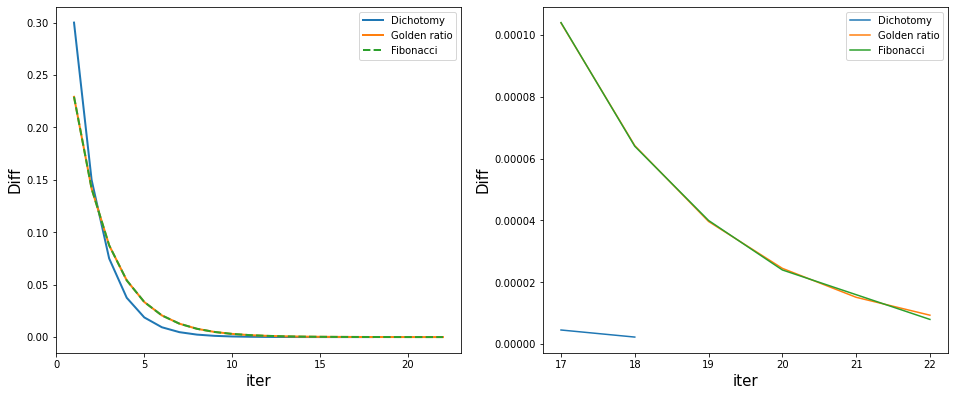

In [4]:
fig = plt.figure(figsize=(16, 14))

# Next iteration
axd = fig.add_subplot(2, 2, 3)
axd.set_xlabel('iter', fontsize=15)
axd.set_ylabel('Diff', fontsize=15)

axd_sc = fig.add_subplot(2, 2, 4)
axd_sc.set_xlabel('iter', fontsize=15)
axd_sc.set_ylabel('Diff', fontsize=15)

for opt_c in opts:
    opt = opt_c(f, 10e-6, [2.2, 2.8])
    opt.opt()
    diffs = []
    prev = -1
    log = opt.log_frame()
    for i, row in log.iterrows():
        now = row['r'] - row['l']
        if i > 0:
            diffs.append(prev - now)
        prev = now
    if opt_c == Fibonacci:
        st = "--"
    else:
        st = "-"
    axd.plot(range(1, len(log)), diffs, label=opt_c.name, linestyle=st, linewidth=2)
    axd_sc.plot(range(1, len(log))[16:], diffs[16:], label=opt_c.name)

axd.legend()
axd_sc.legend()

plt.show()

\newpage
# Задание 2

In [5]:
def markers(min_v: float, max_v: float):
    diff = (max_v - min_v) / 7
    return [min_v + diff * (i + 1) * (1.15 ** i) for i in range(7)]


def plot_graph(ind, fig, opts, sts, mns, title, per, x_expand, y_expand):
    f = opts[0].f
    logs = list(map(lambda x: x.log_frame(), opts))
    logs = list(map(lambda x: x.iloc[-max(3, int(len(x) * per / 100)):], logs))

    x_min = min(list(map(lambda x: min(x['x']), logs)))
    x_max = max(list(map(lambda x: max(x['x']), logs)))
    x_diff = x_max - x_min
    y_min = min(list(map(lambda x: min(x['y']), logs)))
    y_max = max(list(map(lambda x: max(x['y']), logs)))
    y_diff = y_max - y_min

    ax = fig.add_subplot(6, 2, ind)
    n_cnt = 300
    x_axis_min = x_min - x_diff / 2 - x_expand / 2
    x_axis_max = x_max + x_diff / 2 + x_expand / 2
    y_axis_min = y_min - y_diff / 2 - y_expand / 2
    y_axis_max = y_max + y_diff / 2 + y_expand / 2
    ax.set_xlim([x_axis_min, x_axis_max])
    ax.set_ylim([y_axis_min, y_axis_max])
    ax.set_xlabel('X', fontsize=14)
    ax.set_ylabel('Y', fontsize=14)
    ax.set_title(title, fontsize=14)

    xs, ys = np.meshgrid(np.linspace(x_axis_min, x_axis_max, n_cnt), np.linspace(y_axis_min, y_axis_max, n_cnt))

    f_values = np.vectorize(lambda x, y: f(x, y))(xs, ys)
    f_min = min(list(map(lambda x: min(x['f']), logs)))
    f_max = max(list(map(lambda x: max(x['f']), logs)))

    grid_min = np.min(f_values)
    grid_max = np.max(f_values)

    min_v = math.sqrt(f_min * grid_min)
    if f_min < 0 or grid_min < 0:
        min_v = -min_v
    max_v = math.sqrt(f_max * grid_max)
    if f_max < 0 and grid_max < 0:
        max_v = -max_v
    qx = ax.contour(xs, ys, f_values, markers(min_v, max_v))

    lg = math.log10(max_v - min_v)
    if lg < 0:
        pw = int(abs(lg)) + 1
    else:
        if lg > 2:
            pw = 0
        else:
            pw = 1
    ax.clabel(qx, fontsize=8, fmt=f'%.{pw}f', inline=1)
    ax.pcolormesh(xs, ys, f_values, cmap='YlOrBr_r', shading='nearest')

    arrow_color = ["gold", "green", "gray", "blue"]

    for i in range(len(mns)):
        st = sts[i]
        ax.plot(st[0], st[1], 'o', color=arrow_color[i], ms=5, mew=3, label=st)
        mn = mns[i]
        ax.plot(mn[0], mn[1], 'x', color=arrow_color[i], ms=8 + (len(mns) - i) * 3, mew=3)

    for i in range(len(opts)):
        opt = opts[i]
        clr = arrow_color[i]
        last = None
        for ind, e in opt.log_frame().iterrows():
            if last is not None:
                dx = e['x'] - last[0]
                dy = e['y'] - last[1]
                ar_len = math.sqrt(dx ** 2 + dy ** 2)
                head_len = min(2, ar_len / 7)
                width = math.sqrt((x_max - x_min) * (y_max - y_min)) / 250
                ax.arrow(last[0], last[1], e['x'] - last[0], e['y'] - last[1], width=width, color=clr,
                         head_length=head_len, length_includes_head=True)
            last = (e['x'], e['y'])
    ax.legend()

In [ ]:
task2_fun = [
    (lambda x, y: 3 * x ** 2 + 7 * y ** 2 + y * x - x, lambda x, y: np.array([6 * x + y - 1, x + 14 * y])),
    (lambda x, y: (14 - x) ** 2 + 88 * (y - 4 * x + 7) ** 2,
     lambda x, y: np.array([2 * (1409 * x - 352 * y - 2478), 176 * (7 - 4 * x + y)])),
    (lambda x, y: x * math.exp(-(x ** 2 + y ** 2)),
     lambda x, y: np.array([(1 - 2 * x ** 2) * math.exp(-(x ** 2 + y ** 2)),
                            -2 * x * y * math.exp(-(x ** 2 + y ** 2))])),
]

sts = [
    [0.5, 0.1],
    [0, 1],
    [-3, 0.4],
    [-1, 1]
]

frame = []
opts = []
mns = []
for j in range(len(task2_fun)):
    test = task2_fun[j]
    f = Watcher(test[0], test[1])
    _opts = []
    _mns = []
    for st in sts:
        for opt_t in [GoldenRatio, Fibonacci, Dichotomy, BinarySearch]:
            print(j, st, opt_t.name)
            opt = FastestGradientDescent(f, 1e-5, opt_t)
            try:
                start = datetime.datetime.now()
                mn = opt.opt(st)
                elapsed_time = datetime.datetime.now() - start
                frame.append([j, opt_t.name, st, mn, opt.get_iterations_cnt(), f.invocations, f.grad_invocations, elapsed_time])
                if opt_t == GoldenRatio:
                    _mns.append(mn)
                    _opts.append(opt)
            except Exception as error:
                frame.append([j, opt_t.name, repr(error), None, None, None])
    opts.append(_opts)
    mns.append(_mns)

Используется наискорейший градиентный спуск. В качестве процедур одномерной оптимизации используются методы из задания 1 + метод средней точки (он же просто бинарный поиск) на основе производно функции

Для экспериментов использовались следующие функции:

0. $f(x, y) = 3x^2+7y^2+2yx-x$
1. $f(x, y) = (14-x)^2+88(y - 4x + 7)^2$
2. $f(x, y) = xe^{-x^2-y^2}$

Метод запускался из следующих начальных точек:

0. (0.5, 0.1)
1. (0, 1)
2. (-3, 0.4)
3. (-1, 1)

Подробные результаты запусков можно изучить в таблице:

In [16]:
pd.set_option('display.notebook_repr_html', True)

def _repr_latex_(self):
    return self.to_latex(index=False)

pd.DataFrame._repr_latex_ = _repr_latex_  # monkey patch pandas DataFrame

pd_frame = pd.DataFrame(frame, columns=['Function', 'Optimizer', 'Start point', 'Result point', 'Iterations', 'Function calls', 'Gradient calls', 'Elapsed time'])

stats = [{GoldenRatio.name: 0, Fibonacci.name: 0, Dichotomy.name: 0, BinarySearch.name: 0} for i in range(len(task2_fun))]
for ind, r in pd_frame.iterrows():
    stats[r['Function']][r['Optimizer']] += r['Elapsed time'].seconds * 1e6 + r['Elapsed time'].microseconds
pd_frame['Elapsed time'] = pd_frame['Elapsed time'].map(lambda t: f'{t.seconds}.{t.microseconds // 1000}s')
pd_frame['Result point'] = pd_frame['Result point'].map(lambda r: '({:.7f}, {:.7f})'.format(r[0], r[1]))
pd_frame

,Function,Optimizer,Start point,Result point,Iterations,Function calls,Gradient calls,Elapsed time
0,0,Golden ratio,"[0.5, 0.1]","(0.1686819, -0.0120458)",12,455,13,0.3s
1,0,Fibonacci,"[0.5, 0.1]","(0.1686819, -0.0120458)",12,455,13,0.4s
2,0,Dichotomy,"[0.5, 0.1]","(0.1686818, -0.0120457)",12,650,13,0.4s
3,0,Binary search,"[0.5, 0.1]","(0.1686819, -0.0120458)",12,0,338,0.5s
4,0,Golden ratio,"[0, 1]","(0.1686744, -0.0120465)",6,245,7,0.3s
5,0,Fibonacci,"[0, 1]","(0.1686744, -0.0120465)",6,245,7,0.3s
6,0,Dichotomy,"[0, 1]","(0.1686745, -0.0120465)",6,350,7,0.3s
7,0,Binary search,"[0, 1]","(0.1686744, -0.0120465)",6,0,182,0.3s
8,0,Golden ratio,"[-3, 0.4]","(0.1686736, -0.0120548)",3,140,4,0.1s
9,0,Fibonacci,"[-3, 0.4]","(0.1686736, -0.0120549)",3,140,4,0.1s


Сравнение скорости сходимости проводилось по затраченному процессорному времени, так как количество итераций и количество вычислений функции не очень репрентативная иноформация. Нас все равно интересует как быстро мы получим численный ответ в реальной жизни.

Агрегированные результаты можно видеть ниже:

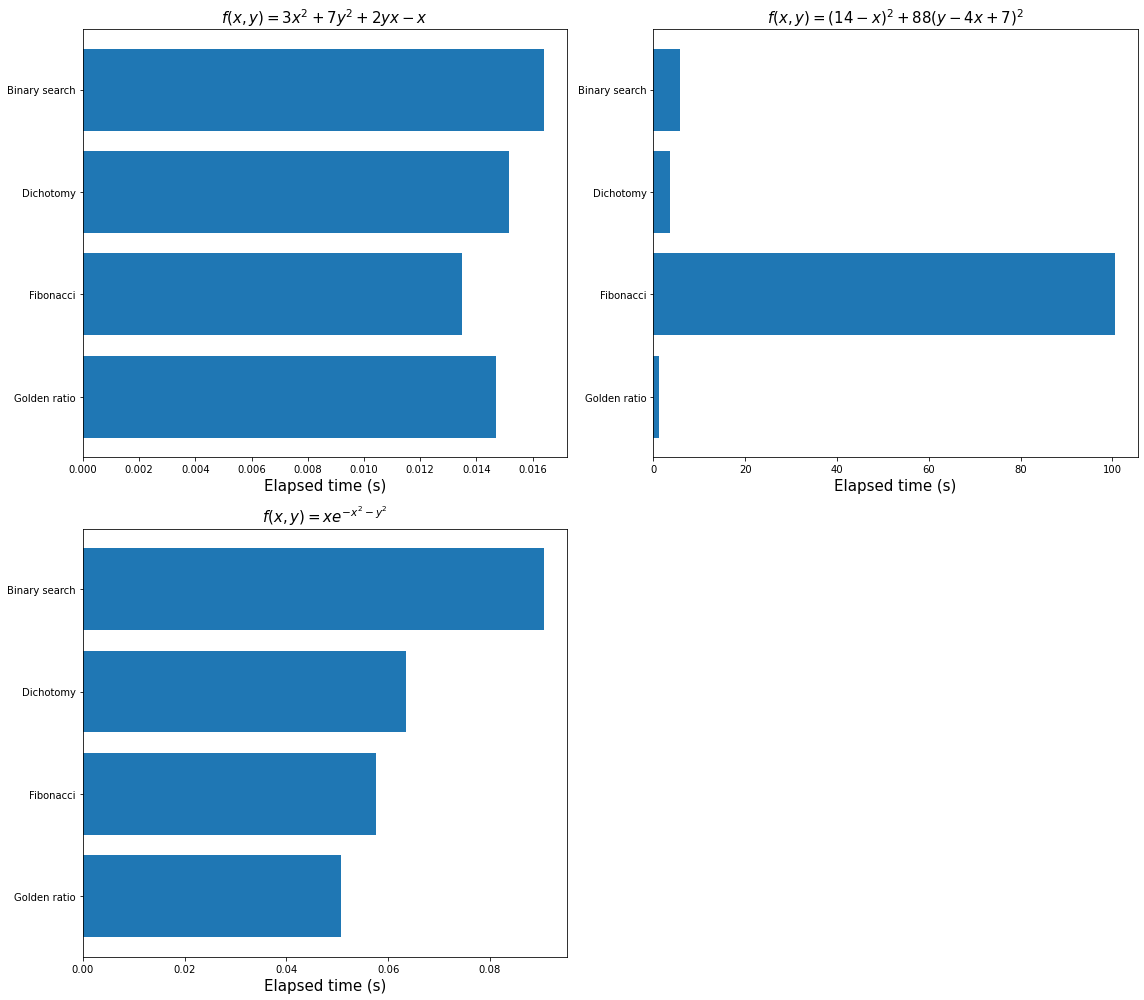

In [14]:
f1_str = '$f(x, y) = 3x^2+7y^2+2yx-x$'
f2_str = '$f(x, y) = (14-x)^2+88(y - 4x + 7)^2$'
f3_str = '$f(x, y) = xe^{-x^2-y^2}$'

titles = [f1_str, f2_str, f3_str]

fig = plt.figure(figsize=(16, 14))

i = 0
for stat in stats:
    ax = fig.add_subplot(2, 2, i + 1)
    ax.set_xlabel('Elapsed time (s)', fontsize=15)
    ax.set_title(titles[i], fontsize=15)

    _opts = list(stat.keys())
    elapsed = [stat[opt] / 1e6 for opt in _opts]
    ax.barh(_opts, elapsed, align='center')
    ax.set_yticks(np.arange(len(_opts)))
    ax.set_yticklabels(_opts)
    i += 1

fig.tight_layout()

Видно, что на 0 и 2 функции методы ведут себя сравнимо. Бинарный поиск проигрывает другим методам скорее всего из-за не самой эффективной реализации вычисления градиента, который он много раз вычисляет

Очень велика разница между методом Фибоначчи и остальными методами на 1 функции. Вероятнее всего это связанно с тем, что данная функция плохо обусловленна (будет видно далее по линиям уровня), из-за чего градиентный спуск в целом сходится плохо. А также из-за того, что из-за операций над большими числами алгоритму не хватает точности на каждом вычислении шага.

\newpage
# Задание 3

На графиках ниже можно наблюдать траектории градиентного спуска (точка на графике - стартовое значение, крестик - результат алгоритма)

Также на графиках изображены линии уровня и сетка раскрашена по значениям функции в точках (чем темнее, тем меньше значение)

Правые графики являются приближением левых с концентрацией на последних итерациях

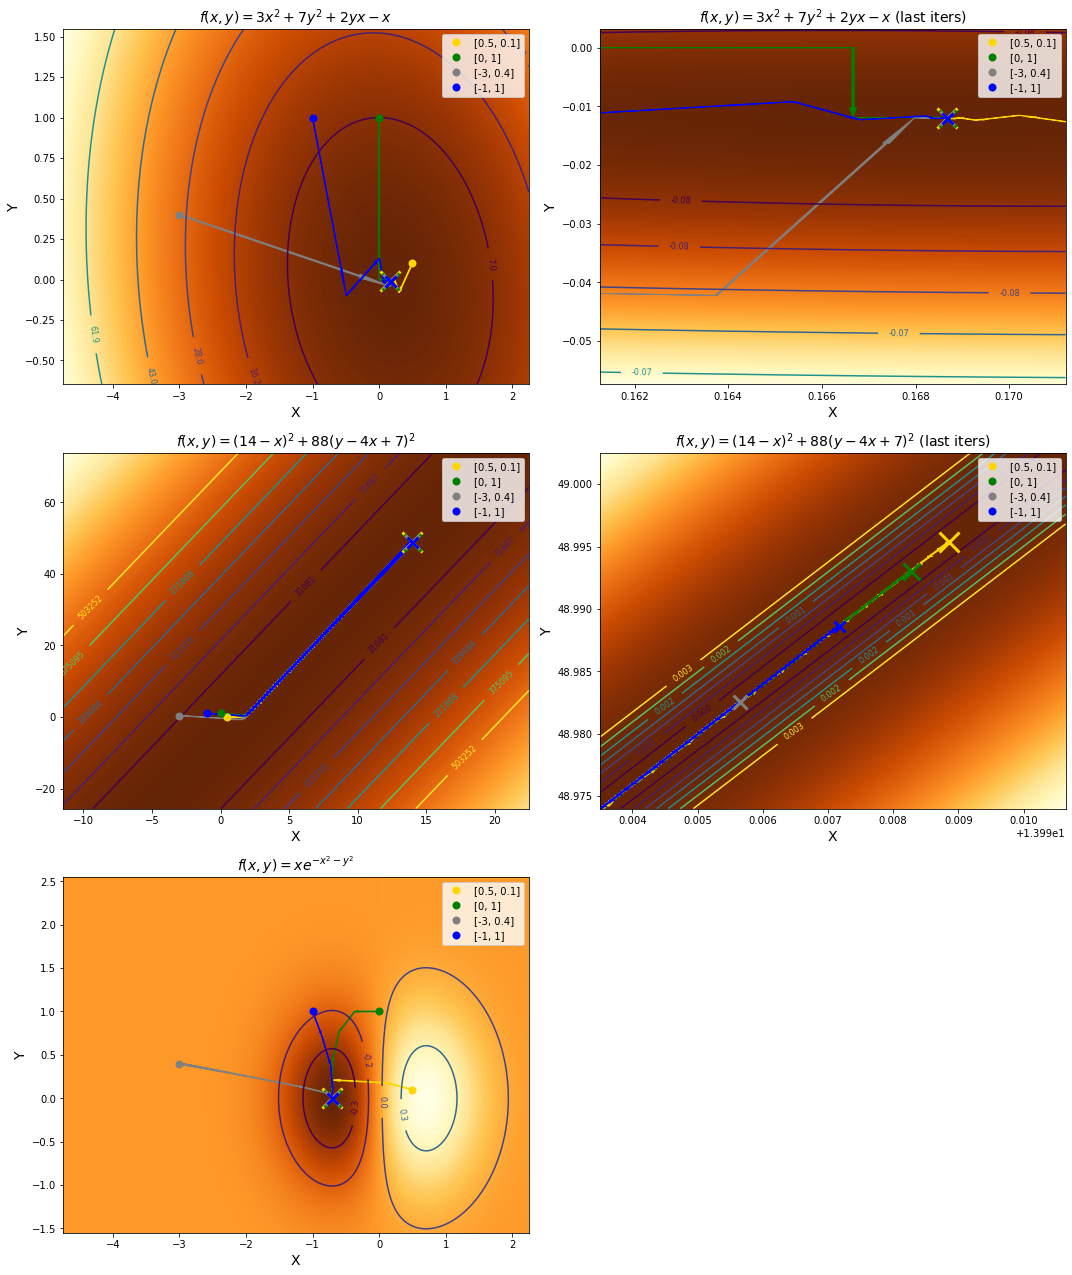

In [21]:
params = [
    [(f1_str, 100, 0, 0), (f1_str + ' (last iters)', 10, 0, 0)],
    [(f2_str, 100, 0, 0), (f2_str + ' (last iters)', 1, 0, 0)],
    [(f3_str, 100, 0, 2.1)],
]

fig = plt.figure(figsize=(15, 35))
i = 0
for j in range(len(task2_fun)):
    test = task2_fun[j]
    for (title, per, x_expand, y_expand) in params[j]:
        i = i + 1
        plot_graph(i, fig, opts[j], sts, mns[j], title, per, x_expand, y_expand)
fig.tight_layout()